# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports 
    }

In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def monte_carlo_dropout_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.train()
    sentiment_model.to(device)
    sentiment_model.train()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()
    aspect_uncertainties = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
                probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
                batch_probs.append(probs)
                
        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)
        aspect_uncertainties.extend(uncertainties)

        for i in range(len(mean_probs)):
            aspect_outputs[batch['ori_indices'][i].item()] = [np.max(torch.sigmoid(outputs[i]).cpu().numpy())]
            
            for j in range(len(mean_probs[i])):
                if int(mean_probs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    aspect_outputs = {i: aspect_uncertainties[i] for i in range(len(aspect_uncertainties))}
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                preds = torch.sigmoid(outputs.logits)

                for j in range(len(preds)):
                    ori_index = batch['ori_indices'][j].item()
                    if ori_index in sentiment_outputs.keys():
                        sentiment_outputs[ori_index].append(preds[j].cpu().numpy())
                    else:
                        sentiment_outputs[ori_index] = [preds[j].cpu().numpy()]

    accelerator.wait_for_everyone()
    for indices, probs in sentiment_outputs.items():
        sentiment_outputs[indices] = [[probs[i], probs[i+1], probs[i+2]] for i in range(int(len(probs) / 3))]
        
        variance = np.var(sentiment_outputs[indices], axis=1)
        mean_aspect_variance = np.mean(variance, axis=1)
        mean_data_variance = np.mean(mean_aspect_variance)
        
        sentiment_outputs[indices] = np.mean(np.mean(np.var(sentiment_outputs[indices], axis=0), axis=0), axis=0)

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = (val + aspect_outputs[key]) / 2

        uncertainties = np.array(list(aspect_outputs.values()))
        sorted_unc = np.argsort(uncertainties)
        sorted_unc = sorted_unc[::-1]

        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
        
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'hoasa-mc-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7629, Accuracy: 0.4733, F1 Micro: 0.5873, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.7254, Accuracy: 0.5719, F1 Micro: 0.6993, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6779, Accuracy: 0.6304, F1 Micro: 0.7608, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.616, Accuracy: 0.6764, F1 Micro: 0.8005, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5873, Accuracy: 0.7193, F1 Micro: 0.8328, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5466, Accuracy: 0.7545, F1 Micro: 0.8574, F1 Macro: 0.8462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.5374, Accuracy: 0.7812, F1 Micro: 0.8753, F1 Macro: 0.868
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4948, Accuracy: 0.7958, F1 Micro: 0.8848, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7093, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6098, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5463, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4848, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4943, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4027, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3762, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4164, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.633, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4618, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4133, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4058, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.389, Accuracy: 0.8045, F1 Micro: 0.8912, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3508, Accuracy: 0.8269, F1 Micro: 0.9017, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3112, Accuracy: 0.8497, F1 Micro: 0.913, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2949, Accuracy: 0.8776, F1 Micro: 0.928, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 9/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4332, Accuracy: 0.7552, F1 Micro: 0.7552, F1 Macro: 0.4303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3204, Accuracy: 0.7552, F1 Micro: 0.7552, F1 Macro: 0.4303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.347, Accuracy: 0.7552, F1 Micro: 0.7552, F1 Macro: 0.4303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.26, Accuracy: 0.7552, F1 Micro: 0.7552, F1 Macro: 0.4303
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2061, Accuracy: 0.7697, F1 Micro: 0.7697, F1 Macro: 0.5003
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1476, Accuracy: 0.8229, F1 Micro: 0.8229, F1 Macro: 0.7004
Epoch 7/10, Train Loss: 0.1288, Accuracy: 0.8148, F1 Micro: 0.8148, F1 Macro: 0.7021
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.8309, F1 Micro: 0.8309, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.8374, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5887, Accuracy: 0.8019, F1 Micro: 0.8897, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4837, Accuracy: 0.8066, F1 Micro: 0.8916, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4461, Accuracy: 0.8274, F1 Micro: 0.8998, F1 Macro: 0.8899
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4045, Accuracy: 0.8601, F1 Micro: 0.9182, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3463, Accuracy: 0.8877, F1 Micro: 0.9329, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2939, Accuracy: 0.9024, F1 Micro: 0.9412, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2585, Accuracy: 0.9137, F1 Micro: 0.948, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2199, Accuracy: 0.9257, F1 Micro: 0.9549, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.536, Accuracy: 0.7442, F1 Micro: 0.7442, F1 Macro: 0.4267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4424, Accuracy: 0.8244, F1 Micro: 0.8244, F1 Macro: 0.7195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.327, Accuracy: 0.8573, F1 Micro: 0.8573, F1 Macro: 0.7982
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2876, Accuracy: 0.8661, F1 Micro: 0.8661, F1 Macro: 0.8161
Epoch 5/10, Train Loss: 0.2361, Accuracy: 0.8551, F1 Micro: 0.8551, F1 Macro: 0.8128
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1608, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1486, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8513
Epoch 8/10, Train Loss: 0.1113, Accuracy: 0.8825, F1 Micro: 0.8825, F1 Macro: 0.8394
Epoch 9/10, Train Loss: 0.1039, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8432
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5769, Accuracy: 0.7979, F1 Micro: 0.8819, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4991, Accuracy: 0.8189, F1 Micro: 0.895, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4275, Accuracy: 0.8646, F1 Micro: 0.9195, F1 Macro: 0.91
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3582, Accuracy: 0.8946, F1 Micro: 0.9366, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2954, Accuracy: 0.9155, F1 Micro: 0.9489, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2374, Accuracy: 0.9359, F1 Micro: 0.9608, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2104, Accuracy: 0.9411, F1 Micro: 0.9639, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1769, Accuracy: 0.9455, F1 Micro: 0.9665, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5931, Accuracy: 0.8181, F1 Micro: 0.8181, F1 Macro: 0.7119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3769, Accuracy: 0.8653, F1 Micro: 0.8653, F1 Macro: 0.8088
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2534, Accuracy: 0.8864, F1 Micro: 0.8864, F1 Macro: 0.8451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2106, Accuracy: 0.8905, F1 Micro: 0.8905, F1 Macro: 0.8526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8558
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8584
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8546
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8509
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.8864, F1 Micro: 0.8864, F1 Macro: 0.837
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0628, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5615, Accuracy: 0.8066, F1 Micro: 0.8903, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4792, Accuracy: 0.8351, F1 Micro: 0.903, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3956, Accuracy: 0.8967, F1 Micro: 0.938, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3089, Accuracy: 0.9269, F1 Micro: 0.9554, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2407, Accuracy: 0.9408, F1 Micro: 0.9635, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2125, Accuracy: 0.9427, F1 Micro: 0.9649, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1816, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1596, Accuracy: 0.95, F1 Micro: 0.9692, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5722, Accuracy: 0.8229, F1 Micro: 0.8229, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3738, Accuracy: 0.8677, F1 Micro: 0.8677, F1 Macro: 0.8252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2909, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.891, F1 Micro: 0.891, F1 Macro: 0.8536
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8482
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8621
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8597
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8609
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8582
Epoch 10/10, Train Loss: 0.0567, Accuracy: 0.8938, F1 Micro: 0.8938, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5491, Accuracy: 0.8031, F1 Micro: 0.8904, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4776, Accuracy: 0.8665, F1 Micro: 0.9214, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3545, Accuracy: 0.9158, F1 Micro: 0.949, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.276, Accuracy: 0.9415, F1 Micro: 0.9642, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2274, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.188, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1651, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1439, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5225, Accuracy: 0.8489, F1 Micro: 0.8489, F1 Macro: 0.7992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3637, Accuracy: 0.8829, F1 Micro: 0.8829, F1 Macro: 0.8531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8794
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8783
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8777
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5581, Accuracy: 0.8049, F1 Micro: 0.8911, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.458, Accuracy: 0.8755, F1 Micro: 0.9258, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.348, Accuracy: 0.9274, F1 Micro: 0.9556, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2635, Accuracy: 0.9457, F1 Micro: 0.9668, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2112, Accuracy: 0.9505, F1 Micro: 0.9695, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1707, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1515, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1328, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4816, Accuracy: 0.8396, F1 Micro: 0.8396, F1 Macro: 0.8082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2974, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.8547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1982, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8887
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8854
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.884
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8723
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8821
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9099, F1 Micro: 0.9099, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.8116, F1 Micro: 0.8921, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4265, Accuracy: 0.8915, F1 Micro: 0.935, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3123, Accuracy: 0.9281, F1 Micro: 0.9563, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2453, Accuracy: 0.946, F1 Micro: 0.9668, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1918, Accuracy: 0.9514, F1 Micro: 0.97, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1663, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9721
Epoch 7/10, Train Loss: 0.142, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1183, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1042, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4621, Accuracy: 0.8649, F1 Micro: 0.8649, F1 Macro: 0.8214
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2937, Accuracy: 0.8787, F1 Micro: 0.8787, F1 Macro: 0.842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1013, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8858
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8817
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8843
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.877
Epoch 10/10, Train Loss: 0.0335, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5329, Accuracy: 0.8118, F1 Micro: 0.8929, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4133, Accuracy: 0.9036, F1 Micro: 0.9421, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2888, Accuracy: 0.9382, F1 Micro: 0.9621, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1833, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1546, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.1106, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.095, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4658, Accuracy: 0.8587, F1 Micro: 0.8587, F1 Macro: 0.8122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8739
Epoch 4/10, Train Loss: 0.123, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9079, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5275, Accuracy: 0.8182, F1 Micro: 0.8973, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4021, Accuracy: 0.9078, F1 Micro: 0.9443, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2839, Accuracy: 0.9417, F1 Micro: 0.9642, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2178, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1801, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1561, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.1116, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0952, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4538, Accuracy: 0.856, F1 Micro: 0.856, F1 Macro: 0.8013
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2811, Accuracy: 0.8832, F1 Micro: 0.8832, F1 Macro: 0.8459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1176, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8805
Epoch 5/10, Train Loss: 0.0917, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8747
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8879
Epoch 8/10, Train Loss: 0.0425, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.881
Epoch 9/10, Train Loss: 0.0255, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.88
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.523, Accuracy: 0.8139, F1 Micro: 0.8945, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4027, Accuracy: 0.908, F1 Micro: 0.9437, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2768, Accuracy: 0.9436, F1 Micro: 0.9654, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2197, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1801, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1493, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1287, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4254, Accuracy: 0.8622, F1 Micro: 0.8622, F1 Macro: 0.8227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.8918, F1 Micro: 0.8918, F1 Macro: 0.8611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8819
Epoch 5/10, Train Loss: 0.0828, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8578
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0709, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8838
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.879
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8878
Epoch 10/10, Train Loss: 0.0414, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5228, Accuracy: 0.8274, F1 Micro: 0.902, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3835, Accuracy: 0.9111, F1 Micro: 0.9463, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2784, Accuracy: 0.9425, F1 Micro: 0.9647, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2114, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1482, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1209, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.1064, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0907, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4137, Accuracy: 0.8657, F1 Micro: 0.8657, F1 Macro: 0.8228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8642
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1319, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.874
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8822
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8643
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8771
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8722
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9083, F1 Micro: 0.9083, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5137, Accuracy: 0.8339, F1 Micro: 0.9027, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3717, Accuracy: 0.9198, F1 Micro: 0.9513, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2582, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1982, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.9646, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0892, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.8118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0739, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0785, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0548, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8874
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8798
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8613
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.507, Accuracy: 0.8339, F1 Micro: 0.9052, F1 Macro: 0.9001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3576, Accuracy: 0.9259, F1 Micro: 0.9552, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9424, F1 Micro: 0.9648, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9719
Epoch 6/10, Train Loss: 0.1393, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4103, Accuracy: 0.8752, F1 Micro: 0.8752, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.244, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1188, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Macro: 0.899
Epoch 5/10, Train Loss: 0.0983, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8874
Epoch 6/10, Train Loss: 0.0601, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8916
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.9236, F1 Micro: 0.9236, F1 Macro: 0.9014
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.8977
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5087, Accuracy: 0.8427, F1 Micro: 0.9084, F1 Macro: 0.8999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3457, Accuracy: 0.9269, F1 Micro: 0.9556, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0821, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8424
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2312, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1192, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8922
Epoch 5/10, Train Loss: 0.0724, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0616, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.8947
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8873
Epoch 9/10, Train Loss: 0.0241, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8823
Epoch 10/10, Train Loss: 0.0355, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5059, Accuracy: 0.841, F1 Micro: 0.9084, F1 Macro: 0.9024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3422, Accuracy: 0.9318, F1 Micro: 0.9586, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2292, Accuracy: 0.9493, F1 Micro: 0.9688, F1 Macro: 0.9665
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9731
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0835, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.863, F1 Micro: 0.863, F1 Macro: 0.828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2182, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1486, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0844, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8874
Epoch 6/10, Train Loss: 0.05, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0504, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8895
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8884
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5022, Accuracy: 0.8514, F1 Micro: 0.9133, F1 Macro: 0.9055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3306, Accuracy: 0.9385, F1 Micro: 0.9624, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2321, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9599, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2203, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8718
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8825
Epoch 4/10, Train Loss: 0.1112, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0809, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8851
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8806
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8827
Epoch 8/10, Train Loss: 0.0405, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8838
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8843
Epoch 10/10, Train Loss: 0.0191, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8848

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4946, Accuracy: 0.8601, F1 Micro: 0.9189, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3271, Accuracy: 0.933, F1 Micro: 0.9592, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.947, F1 Micro: 0.9676, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3515, Accuracy: 0.8725, F1 Micro: 0.8725, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.093, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8908
Epoch 5/10, Train Loss: 0.0614, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0604, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8935
Epoch 7/10, Train Loss: 0.045, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.883
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8927
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4872, Accuracy: 0.8623, F1 Micro: 0.9194, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3167, Accuracy: 0.9306, F1 Micro: 0.9577, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3496, Accuracy: 0.8693, F1 Micro: 0.8693, F1 Macro: 0.8276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.209, Accuracy: 0.8857, F1 Micro: 0.8857, F1 Macro: 0.8506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1457, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1176, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0755, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8859
Epoch 6/10, Train Loss: 0.0621, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.878
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8791
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8695
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.884
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4848, Accuracy: 0.8649, F1 Micro: 0.92, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3071, Accuracy: 0.9321, F1 Micro: 0.9588, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.9443, F1 Micro: 0.966, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3659, Accuracy: 0.8679, F1 Micro: 0.8679, F1 Macro: 0.817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1266, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.9014
Epoch 7/10, Train Loss: 0.053, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9049
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8943
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.8622, F1 Micro: 0.9199, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3053, Accuracy: 0.9396, F1 Micro: 0.963, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.958, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3551, Accuracy: 0.8702, F1 Micro: 0.8702, F1 Macro: 0.8242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.8861, F1 Micro: 0.8861, F1 Macro: 0.8613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1495, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.088, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8953
Epoch 5/10, Train Loss: 0.0746, Accuracy: 0.9169, F1 Micro: 0.9169, F1 Macro: 0.8942
Epoch 6/10, Train Loss: 0.0539, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8883
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8952
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9009
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4727, Accuracy: 0.8687, F1 Micro: 0.9227, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3028, Accuracy: 0.9295, F1 Micro: 0.9574, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.07, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3449, Accuracy: 0.8588, F1 Micro: 0.8588, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2096, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.139, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1138, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0848, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8823
Epoch 6/10, Train Loss: 0.0517, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0497, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8816
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8726
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8571
Epoch 10/10, Train Loss: 0.0159, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.879, F1 Micro: 0.928, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2877, Accuracy: 0.9387, F1 Micro: 0.9626, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3484, Accuracy: 0.8664, F1 Micro: 0.8664, F1 Macro: 0.8235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.184, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8709
Epoch 3/10, Train Loss: 0.1399, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0977, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0594, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8882
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.889
Epoch 8/10, Train Loss: 0.0302, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8701
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.881
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4655, Accuracy: 0.8776, F1 Micro: 0.9278, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2829, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9602, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3533, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2078, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1393, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8898
Epoch 4/10, Train Loss: 0.0985, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.875
Epoch 5/10, Train Loss: 0.0777, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8843
Epoch 6/10, Train Loss: 0.0515, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8819
Epoch 7/10, Train Loss: 0.0424, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8861
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8856
Epoch 9/10, Train Loss: 0.0222, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8851
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8892

Sentiment analysis accuracy: 0.9156, F1 Micro: 0.9156, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4591, Accuracy: 0.8804, F1 Micro: 0.9292, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.9417, F1 Micro: 0.9643, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9556, F1 Micro: 0.9727, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3375, Accuracy: 0.8759, F1 Micro: 0.8759, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2044, Accuracy: 0.8805, F1 Micro: 0.8805, F1 Macro: 0.8357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1356, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.103, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8848
Epoch 5/10, Train Loss: 0.0768, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8793
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.879
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8832
Epoch 10/10, Train Loss: 0.0309, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4582, Accuracy: 0.8859, F1 Micro: 0.9321, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.938, F1 Micro: 0.9622, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.95, F1 Micro: 0.9692, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9563, F1 Micro: 0.9731, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3659, Accuracy: 0.8708, F1 Micro: 0.8708, F1 Macro: 0.8297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8752
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1344, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1088, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8816
Epoch 5/10, Train Loss: 0.0922, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.869
Epoch 6/10, Train Loss: 0.0717, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8845
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8874
Epoch 10/10, Train Loss: 0.0326, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4513, Accuracy: 0.8847, F1 Micro: 0.9315, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1795, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3534, Accuracy: 0.8591, F1 Micro: 0.8591, F1 Macro: 0.813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1366, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8769
Epoch 4/10, Train Loss: 0.1144, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.081, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0603, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0552, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8832
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8773
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8794
Epoch 10/10, Train Loss: 0.0309, Accurac

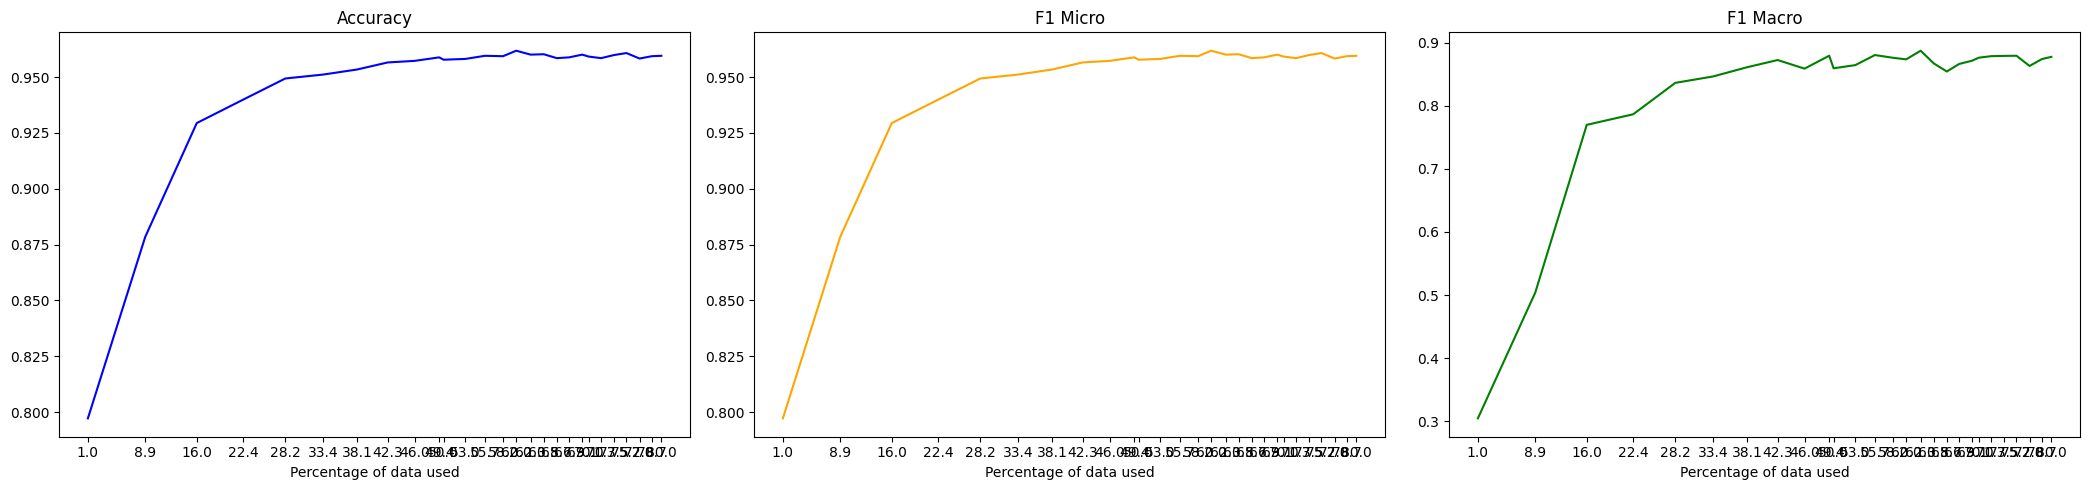

In [21]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6304, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Epoch 2/10, Train Loss: 0.4839, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4257, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4169, Accuracy: 0.8304, F1 Micro: 0.9037, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3785, Accuracy: 0.8505, F1 Micro: 0.9137, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3439, Accuracy: 0.8767, F1 Micro: 0.9277, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8839, F1 Micro: 0.9316, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.274, Accuracy: 0.9042, F1 Micro: 0.9423, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5629, Accuracy: 0.7088, F1 Micro: 0.7088, F1 Macro: 0.4148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3944, Accuracy: 0.7804, F1 Micro: 0.7804, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3384, Accuracy: 0.7995, F1 Micro: 0.7995, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2906, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.233, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2122, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1913, Accuracy: 0.8222, F1 Micro: 0.8222, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1635, Accuracy: 0.8305, F1 Micro: 0.8305, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.1457, Accuracy: 0.8103, F1 Micro: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5767, Accuracy: 0.8002, F1 Micro: 0.8859, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.482, Accuracy: 0.8062, F1 Micro: 0.8903, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4465, Accuracy: 0.8292, F1 Micro: 0.903, F1 Macro: 0.8982
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3993, Accuracy: 0.8727, F1 Micro: 0.9238, F1 Macro: 0.9098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3468, Accuracy: 0.8998, F1 Micro: 0.9395, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2853, Accuracy: 0.9148, F1 Micro: 0.9483, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2517, Accuracy: 0.9302, F1 Micro: 0.9574, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2166, Accuracy: 0.933, F1 Micro: 0.9591, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.59, Accuracy: 0.7684, F1 Micro: 0.7684, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4367, Accuracy: 0.8339, F1 Micro: 0.8339, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2905, Accuracy: 0.8484, F1 Micro: 0.8484, F1 Macro: 0.7951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2467, Accuracy: 0.8598, F1 Micro: 0.8598, F1 Macro: 0.7955
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.8525, F1 Micro: 0.8525, F1 Macro: 0.8046
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2027, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.8847, F1 Micro: 0.8847, F1 Macro: 0.833
Epoch 8/10, Train Loss: 0.1047, Accuracy: 0.8837, F1 Micro: 0.8837, F1 Macro: 0.834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0954, Accuracy: 0.8879, F1 Micro: 0.8879, F1 Macro: 0.8383
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5696, Accuracy: 0.8043, F1 Micro: 0.8896, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4896, Accuracy: 0.8253, F1 Micro: 0.8977, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4261, Accuracy: 0.8609, F1 Micro: 0.9178, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3513, Accuracy: 0.9033, F1 Micro: 0.9416, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2868, Accuracy: 0.9311, F1 Micro: 0.9578, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2317, Accuracy: 0.9415, F1 Micro: 0.9641, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2052, Accuracy: 0.9444, F1 Micro: 0.966, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1744, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5532, Accuracy: 0.775, F1 Micro: 0.775, F1 Macro: 0.7317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3866, Accuracy: 0.851, F1 Micro: 0.851, F1 Macro: 0.7928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2717, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.827
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8115
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.8865, F1 Micro: 0.8865, F1 Macro: 0.8483
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.8837, F1 Micro: 0.8837, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8571
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.8913, F1 Micro: 0.8913, F1 Macro: 0.8538
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.8913, F1 Micro: 0.8913, F1 Macro: 0.8546
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5647, Accuracy: 0.7997, F1 Micro: 0.8832, F1 Macro: 0.8469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4792, Accuracy: 0.8347, F1 Micro: 0.9037, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3942, Accuracy: 0.9, F1 Micro: 0.9393, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3067, Accuracy: 0.9266, F1 Micro: 0.9552, F1 Macro: 0.9516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.25, Accuracy: 0.9363, F1 Micro: 0.9611, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2134, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1794, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1614, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5446, Accuracy: 0.8386, F1 Micro: 0.8386, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3768, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.266, Accuracy: 0.8883, F1 Micro: 0.8883, F1 Macro: 0.8535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8703
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8593
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8542
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8622
Epoch 10/10, Train Loss: 0.0479, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5541, Accuracy: 0.8082, F1 Micro: 0.8927, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4761, Accuracy: 0.8557, F1 Micro: 0.9157, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3631, Accuracy: 0.9155, F1 Micro: 0.949, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2798, Accuracy: 0.9389, F1 Micro: 0.9624, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2276, Accuracy: 0.9502, F1 Micro: 0.9693, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1865, Accuracy: 0.9523, F1 Micro: 0.9705, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1615, Accuracy: 0.9528, F1 Micro: 0.9708, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.141, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5157, Accuracy: 0.8524, F1 Micro: 0.8524, F1 Macro: 0.8057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3395, Accuracy: 0.8709, F1 Micro: 0.8709, F1 Macro: 0.8301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2251, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8736
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8658
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8691
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8698
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.8904, F1 Micro: 0.8904, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0224, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8759
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5549, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4713, Accuracy: 0.8799, F1 Micro: 0.929, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3362, Accuracy: 0.9295, F1 Micro: 0.957, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2637, Accuracy: 0.9457, F1 Micro: 0.9666, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.208, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1794, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1537, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1306, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.1106, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4875, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.79
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2987, Accuracy: 0.8764, F1 Micro: 0.8764, F1 Macro: 0.8307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8786
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0821, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.882
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8701
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8768
Epoch 10/10, Train Loss: 0.0341, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5483, Accuracy: 0.8042, F1 Micro: 0.8866, F1 Macro: 0.8621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4474, Accuracy: 0.8852, F1 Micro: 0.9321, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3216, Accuracy: 0.9335, F1 Micro: 0.9591, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2407, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2005, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1762, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1462, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9723
Epoch 8/10, Train Loss: 0.1258, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1067, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8563, F1 Micro: 0.8563, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2974, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1919, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.875
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1028, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8847
Epoch 7/10, Train Loss: 0.0544, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8747
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8794
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8895
Epoch 10/10, Train Loss: 0.0302, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5367, Accuracy: 0.8128, F1 Micro: 0.895, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4251, Accuracy: 0.904, F1 Micro: 0.9417, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2974, Accuracy: 0.9368, F1 Micro: 0.9614, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2305, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1901, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1598, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1383, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1207, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.1004, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4386, Accuracy: 0.8651, F1 Micro: 0.8651, F1 Macro: 0.8178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.8888, F1 Micro: 0.8888, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1626, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1049, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0727, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8865
Epoch 8/10, Train Loss: 0.0284, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8784
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8775
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.8066, F1 Micro: 0.8922, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4087, Accuracy: 0.9122, F1 Micro: 0.9467, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2794, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2185, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1771, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1561, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1313, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0981, Accuracy: 0.9639, F1 Micro: 0.9776, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4138, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1795, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1319, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8832
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8905
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8929
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5292, Accuracy: 0.8146, F1 Micro: 0.8961, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.414, Accuracy: 0.9095, F1 Micro: 0.9454, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2922, Accuracy: 0.9417, F1 Micro: 0.9643, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2231, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1874, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1595, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0968, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3986, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1583, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1066, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0986, Accuracy: 0.9239, F1 Micro: 0.9239, F1 Macro: 0.9013
Epoch 6/10, Train Loss: 0.0587, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8933
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8965
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.923, F1 Micro: 0.923, F1 Macro: 0.8997
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.9
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.923, F1 Micro: 0.923, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5253, Accuracy: 0.8205, F1 Micro: 0.899, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3787, Accuracy: 0.9182, F1 Micro: 0.9505, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2723, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2137, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1757, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1091, Accuracy: 0.967, F1 Micro: 0.9795, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0893, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4127, Accuracy: 0.8705, F1 Micro: 0.8705, F1 Macro: 0.8354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.8862, F1 Micro: 0.8862, F1 Macro: 0.8613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1482, Accuracy: 0.9204, F1 Micro: 0.9204, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1036, Accuracy: 0.9241, F1 Micro: 0.9241, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0954, Accuracy: 0.9241, F1 Micro: 0.9241, F1 Macro: 0.9019
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9047
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.9241, F1 Micro: 0.9241, F1 Macro: 0.9014
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9232, F1 Micro: 0.9232, F1 Macro: 0.9008
Epoch 10/10, Train Loss: 0.0423, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5156, Accuracy: 0.8163, F1 Micro: 0.8963, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.378, Accuracy: 0.9163, F1 Micro: 0.9495, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2646, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2072, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9644, F1 Micro: 0.978, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3942, Accuracy: 0.8749, F1 Micro: 0.8749, F1 Macro: 0.8273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8719
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8877
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0937, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0715, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8964
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8938
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8935
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0314, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5192, Accuracy: 0.8316, F1 Micro: 0.9023, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3625, Accuracy: 0.926, F1 Micro: 0.9549, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2046, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1696, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9728
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4026, Accuracy: 0.8606, F1 Micro: 0.8606, F1 Macro: 0.8198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.226, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1555, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1327, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0828, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8778
Epoch 6/10, Train Loss: 0.0736, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8732
Epoch 7/10, Train Loss: 0.053, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8762
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8707
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8777
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5044, Accuracy: 0.8391, F1 Micro: 0.9074, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3491, Accuracy: 0.9309, F1 Micro: 0.9577, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2436, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1963, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1209, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.381, Accuracy: 0.8714, F1 Micro: 0.8714, F1 Macro: 0.8385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2193, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8825
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1022, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.075, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.8955
Epoch 6/10, Train Loss: 0.0591, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8935
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8782
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8836
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8922
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8879

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5071, Accuracy: 0.8498, F1 Micro: 0.9134, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3442, Accuracy: 0.9255, F1 Micro: 0.955, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2267, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8844
Epoch 4/10, Train Loss: 0.1189, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.886
Epoch 6/10, Train Loss: 0.072, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8813
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8872
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.886
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8728
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8831

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4979, Accuracy: 0.8474, F1 Micro: 0.9116, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3331, Accuracy: 0.937, F1 Micro: 0.9613, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9552, F1 Micro: 0.9725, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.373, Accuracy: 0.8612, F1 Micro: 0.8612, F1 Macro: 0.8192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2312, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1197, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0941, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.884
Epoch 6/10, Train Loss: 0.0644, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8807
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8761
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.879
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.879
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4932, Accuracy: 0.8516, F1 Micro: 0.9145, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3245, Accuracy: 0.9325, F1 Micro: 0.9589, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.9481, F1 Micro: 0.9683, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9554, F1 Micro: 0.9726, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.076, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.8723, F1 Micro: 0.8723, F1 Macro: 0.8301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2209, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1453, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.892
Epoch 4/10, Train Loss: 0.1055, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0698, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8952
Epoch 6/10, Train Loss: 0.0516, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8951
Epoch 8/10, Train Loss: 0.026, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8881
Epoch 9/10, Train Loss: 0.0182, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8846
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.486, Accuracy: 0.8594, F1 Micro: 0.9169, F1 Macro: 0.9075
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3217, Accuracy: 0.9328, F1 Micro: 0.9592, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9672
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9491, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3752, Accuracy: 0.8487, F1 Micro: 0.8487, F1 Macro: 0.7935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2137, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1321, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8823
Epoch 4/10, Train Loss: 0.0895, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0741, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.888
Epoch 6/10, Train Loss: 0.057, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0506, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0335, Accuracy: 0.9212, F1 Micro: 0.9212, F1 Macro: 0.8982
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8903
Epoch 10/10, Train Loss: 0.0219, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4857, Accuracy: 0.8632, F1 Micro: 0.9197, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3114, Accuracy: 0.9328, F1 Micro: 0.9592, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3434, Accuracy: 0.8706, F1 Micro: 0.8706, F1 Macro: 0.824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2112, Accuracy: 0.8936, F1 Micro: 0.8936, F1 Macro: 0.859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1431, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8881
Epoch 4/10, Train Loss: 0.0965, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8833
Epoch 5/10, Train Loss: 0.0726, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8782
Epoch 6/10, Train Loss: 0.0627, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8755
Epoch 7/10, Train Loss: 0.0529, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.882
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8857
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8865
Epoch 10/10, Train Loss: 0.0236, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8851

Sentiment analysis accuracy: 0.9156, F1 Micro: 0.915

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4817, Accuracy: 0.87, F1 Micro: 0.9238, F1 Macro: 0.918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.307, Accuracy: 0.9361, F1 Micro: 0.9607, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9769
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.8661, F1 Micro: 0.8661, F1 Macro: 0.8239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2089, Accuracy: 0.8946, F1 Micro: 0.8946, F1 Macro: 0.8618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1104, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8844
Epoch 6/10, Train Loss: 0.0622, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8801
Epoch 7/10, Train Loss: 0.0403, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8767
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8854
Epoch 10/10, Train Loss: 0.03, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4737, Accuracy: 0.8726, F1 Micro: 0.9246, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2981, Accuracy: 0.933, F1 Micro: 0.9592, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9651, F1 Micro: 0.9782, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.8667, F1 Micro: 0.8667, F1 Macro: 0.8354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.199, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1267, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0906, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8885
Epoch 5/10, Train Loss: 0.0673, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8794
Epoch 6/10, Train Loss: 0.0538, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8918
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.892
Epoch 10/10, Train Loss: 0.0288, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4711, Accuracy: 0.8753, F1 Micro: 0.9266, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2886, Accuracy: 0.933, F1 Micro: 0.9593, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Epoch 10/10, Train Loss: 0.0584, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3495, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2099, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8891
Epoch 4/10, Train Loss: 0.0933, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8673
Epoch 5/10, Train Loss: 0.0786, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8846
Epoch 6/10, Train Loss: 0.0667, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8949
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8835
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8935
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8864

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4633, Accuracy: 0.883, F1 Micro: 0.9303, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2846, Accuracy: 0.9321, F1 Micro: 0.9588, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.8587, F1 Micro: 0.8587, F1 Macro: 0.7968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2, Accuracy: 0.8938, F1 Micro: 0.8938, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1314, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1096, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0816, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.898
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0357, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9006
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.89
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8875
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8865, F1 Micro: 0.9324, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2692, Accuracy: 0.9321, F1 Micro: 0.9588, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9639, F1 Micro: 0.9777, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0615, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3405, Accuracy: 0.8574, F1 Micro: 0.8574, F1 Macro: 0.799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.204, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.139, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1008, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8925
Epoch 5/10, Train Loss: 0.0839, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8904
Epoch 6/10, Train Loss: 0.0505, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8795
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8877
Epoch 8/10, Train Loss: 0.0443, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8897
Epoch 9/10, Train Loss: 0.0312, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8837
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8811

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4511, Accuracy: 0.8842, F1 Micro: 0.931, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.9406, F1 Micro: 0.9636, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3455, Accuracy: 0.8655, F1 Micro: 0.8655, F1 Macro: 0.8328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.207, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.136, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8814
Epoch 4/10, Train Loss: 0.0946, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8721
Epoch 5/10, Train Loss: 0.0825, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8761
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8863
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0354, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4525, Accuracy: 0.8821, F1 Micro: 0.9304, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9495, F1 Micro: 0.9689, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9507, F1 Micro: 0.9698, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9656, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3279, Accuracy: 0.8543, F1 Micro: 0.8543, F1 Macro: 0.7923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1831, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.124, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8884
Epoch 4/10, Train Loss: 0.0789, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8868
Epoch 5/10, Train Loss: 0.0612, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.885
Epoch 6/10, Train Loss: 0.0478, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0342, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8892
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0181, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8943
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9148, F1 Micro: 0.9148, F1 

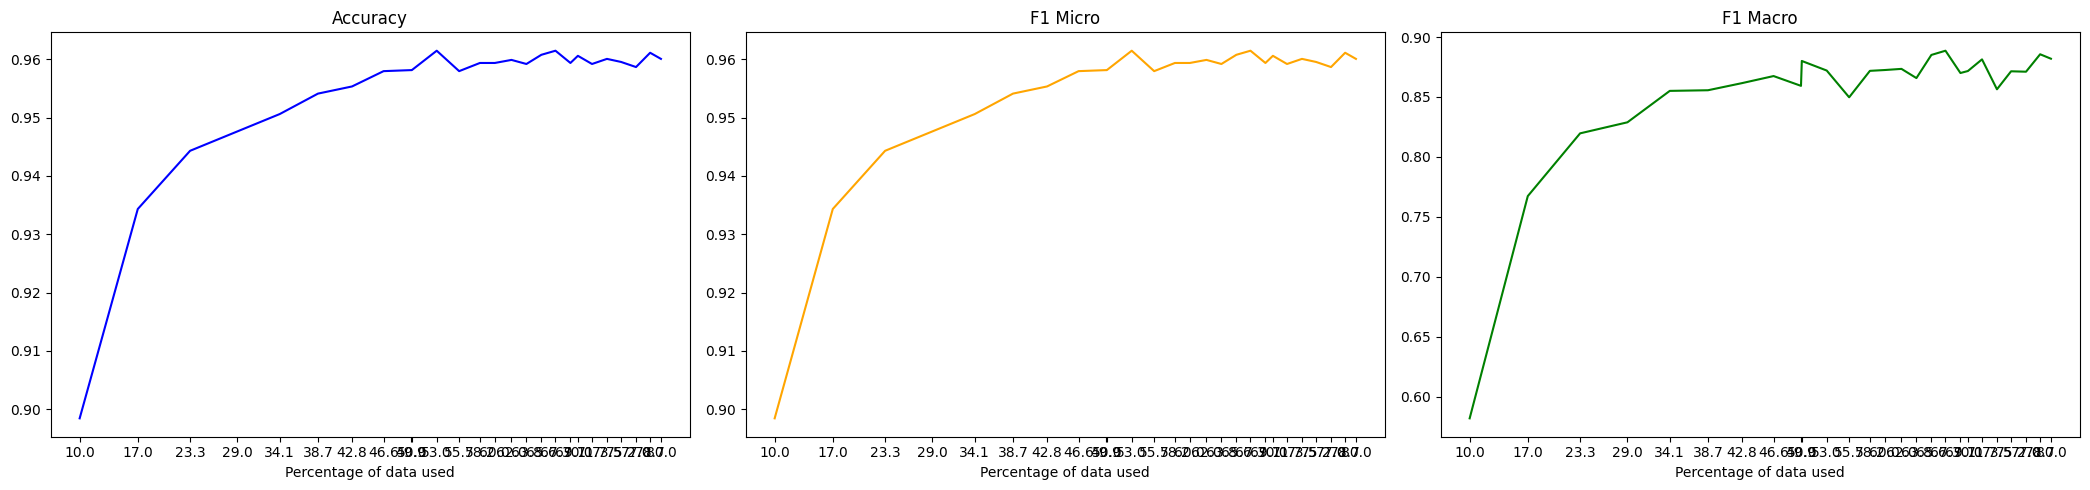

In [22]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)